In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("merged-df.csv")

print(df.shape)
print(df.head())


(13305915, 36)
   transaction_id                 date  user_id  card_id  amount  \
0         7475327  2010-01-01 00:01:00     1556     2972  -77.00   
1         7475328  2010-01-01 00:02:00      561     4575   14.57   
2         7475329  2010-01-01 00:02:00     1129      102   80.00   
3         7475331  2010-01-01 00:05:00      430     2860  200.00   
4         7475332  2010-01-01 00:06:00      848     3915   46.41   

            use_chip  merchant_id merchant_city merchant_state    zip  ...  \
0  Swipe Transaction        59935        Beulah             ND  58523  ...   
1  Swipe Transaction        67570    Bettendorf             IA  52722  ...   
2  Swipe Transaction        27092         Vista             CA  92084  ...   
3  Swipe Transaction        27092   Crown Point             IN  46307  ...   
4  Swipe Transaction        13051       Harwood             MD  20776  ...   

   card_card_brand   card_card_type card_has_chip  card_cvv  card_expires  \
0       Mastercard  Debit (Pre

In [3]:
df = df.sort_values(['user_id', 'date'])

# keep last 500 txn
df_recent = df.groupby('user_id', group_keys=False).apply(lambda x: x.tail(500)).reset_index(drop=True)

print(f"txns: {len(df_recent)}")
print(f"users: {df_recent['user_id'].nunique()}")

/var/tmp/ipykernel_24099/3302370172.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_recent = df.groupby('user_id', group_keys=False).apply(lambda x: x.tail(500)).reset_index(drop=True)


txns: 609500
users: 1219


In [4]:
df_recent.to_csv("recent500.csv", index=False)

In [6]:
df = pd.read_csv("recent500.csv")

In [7]:
print(df.shape)
print(df.head())

(609500, 36)
   transaction_id                 date  user_id  card_id  amount  \
0        23090763  2019-06-11 22:26:00        0     4639   13.26   
1        23097701  2019-06-13 12:34:00        0     4639   50.10   
2        23098009  2019-06-13 13:28:00        0     1271   55.06   
3        23099658  2019-06-13 20:31:00        0     4639   49.17   
4        23102852  2019-06-14 13:28:00        0     4639   45.35   

           use_chip  merchant_id merchant_city merchant_state    zip  ...  \
0  Chip Transaction        30055      Portland             ME  04103  ...   
1  Chip Transaction        16256   Scarborough             ME  04074  ...   
2  Chip Transaction        26593   Scarborough             ME  04074  ...   
3  Chip Transaction        69956    Springvale             ME  04083  ...   
4  Chip Transaction        43925   Scarborough             ME  04074  ...   

   card_card_brand card_card_type card_has_chip  card_cvv  card_expires  \
0       Mastercard         Credit       

In [8]:
user_counts = df['user_id'].value_counts().reset_index()
user_counts.columns = ['user_id', 'num_transactions']

In [9]:
print(user_counts)

      user_id  num_transactions
0        1998               500
1           0               500
2           1               500
3        1940               500
4        1941               500
...       ...               ...
1214       11               500
1215       13               500
1216       14               500
1217       16               500
1218       17               500

[1219 rows x 2 columns]


In [10]:
drop_cols = ['card_cvv', 'card_year_pin_last_changed']
df = df.drop(columns=drop_cols, errors='ignore')

In [11]:
df['amount_log'] = np.sign(df['amount']) * np.log1p(np.abs(df['amount']))
df['date'] = pd.to_datetime(df['date'])
df['user_birth_year'] = df['user_birth_year'].astype(float)
df['user_age_at_txn'] = df['date'].dt.year - df['user_birth_year']
for col in ['user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'card_credit_limit']:
    df[col] = np.log1p(df[col])

df['debt_to_income'] = df['user_total_debt'] / (df['user_yearly_income'] + 1e-6)
df['credit_utilization'] = df['amount'].abs() / (df['card_credit_limit'] + 1e-6)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

user_ids = df['user_id'].unique()

train_users, val_users = train_test_split(user_ids, test_size=0.2, random_state=42)

train_df = df[df['user_id'].isin(train_users)].copy()
val_df   = df[df['user_id'].isin(val_users)].copy()

print(train_df.head())

   transaction_id                date  user_id  card_id  amount  \
0        23090763 2019-06-11 22:26:00        0     4639   13.26   
1        23097701 2019-06-13 12:34:00        0     4639   50.10   
2        23098009 2019-06-13 13:28:00        0     1271   55.06   
3        23099658 2019-06-13 20:31:00        0     4639   49.17   
4        23102852 2019-06-14 13:28:00        0     4639   45.35   

           use_chip  merchant_id merchant_city merchant_state    zip  ...  \
0  Chip Transaction        30055      Portland             ME  04103  ...   
1  Chip Transaction        16256   Scarborough             ME  04074  ...   
2  Chip Transaction        26593   Scarborough             ME  04074  ...   
3  Chip Transaction        69956    Springvale             ME  04083  ...   
4  Chip Transaction        43925   Scarborough             ME  04074  ...   

   card_has_chip card_expires card_num_cards_issued  card_credit_limit  \
0            YES   2019-12-01                     1         

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# numeric
num_cols = [
    'amount_log', 'user_age_at_txn', 'user_credit_score',
    'user_num_credit_cards', 'card_num_cards_issued',
    'card_credit_limit', 'user_per_capita_income',
    'user_yearly_income', 'user_total_debt',
    'debt_to_income', 'credit_utilization'
]

# --- normalize ---
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

# --- geo cluster ---
coords = train_df[['user_latitude', 'user_longitude']]
kmeans = KMeans(n_clusters=10, random_state=42)
train_df['geo_cluster'] = kmeans.fit_predict(coords)

val_df[num_cols] = scaler.transform(val_df[num_cols])
val_df['geo_cluster'] = kmeans.predict(val_df[['user_latitude', 'user_longitude']])

In [14]:
from sklearn.preprocessing import LabelEncoder
cat_cols = [
    'merchant_id','merchant_city','merchant_state','mcc','category',
    'card_card_brand','card_card_type','user_gender','card_has_chip','card_card_on_dark_web'
]

label_encoders = {}
embedding_spec = {}                

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le
    n = len(le.classes_) + 1        
    d = int(min(50, round(1.6 * (n ** 0.56))))
    embedding_spec[col] = (n, d)

for col in cat_cols:
    le = label_encoders[col]
    val_df[col] = val_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else len(le.classes_))
embedding_sizes = [embedding_spec[col] for col in cat_cols]

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TransactionDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, user_col='user_id', target_col='amount_log', window_size=5):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        self.user_col = user_col
        self.target_col = target_col
        self.window_size = window_size
        self.samples = []

        for uid, user_df in df.groupby(user_col):
            user_df = user_df.sort_values('date')
            if len(user_df) <= window_size:
                continue
            X_num = user_df[num_cols].values
            X_cat = user_df[cat_cols].values
            y = user_df[target_col].values
            for i in range(len(user_df) - window_size):
                self.samples.append((
                    X_num[i:i+window_size],
                    X_cat[i:i+window_size],
                    y[i+window_size]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X_num, X_cat, y = self.samples[idx]
        return (
            torch.tensor(X_num, dtype=torch.float32),
            torch.tensor(X_cat, dtype=torch.long),
            torch.tensor(y, dtype=torch.float32)
        )

In [20]:
import torch
import torch.nn as nn

class SafeEmbeddingConcat(nn.Module):
    def __init__(self, cat_cols, embedding_sizes, num_numeric_features):
        super().__init__()
        assert len(cat_cols) == len(embedding_sizes)
        self.cat_cols = cat_cols
        self.emb_layers = nn.ModuleDict({
            col: nn.Embedding(num_cat, emb_dim)
            for col, (num_cat, emb_dim) in zip(cat_cols, embedding_sizes)
        })
        self.output_dim = sum(dim for (_, dim) in embedding_sizes) + num_numeric_features


    def forward(self, x_num, x_cat):
        embs = [self.emb_layers[col](x_cat[:, :, i]) for i, col in enumerate(self.cat_cols)]
        emb_cat = torch.cat(embs, dim=-1)
        return torch.cat([x_num, emb_cat], dim=-1)



In [21]:
class LSTMAmountPredictor(nn.Module):
    def __init__(self, cat_cols, embedding_sizes, num_numeric_features, hidden_dim=128, num_layers=2):
        super().__init__()
        self.emb_concat = SafeEmbeddingConcat(cat_cols, embedding_sizes, num_numeric_features)
        self.lstm = nn.LSTM(
            input_size=self.emb_concat.output_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x_num, x_cat):
        x = self.emb_concat(x_num, x_cat)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model = LSTMAmountPredictor(cat_cols,embedding_sizes, len(num_cols))


# hyperparam
BATCH_SIZE = 128
EPOCHS = 30
LR = 1e-3
PATIENCE = 10   

train_dataset = TransactionDataset(
    df=train_df,
    num_cols=num_cols,
    cat_cols=cat_cols,
    user_col='user_id',
    target_col='amount_log',
    window_size=5
)

val_dataset = TransactionDataset(
    df=val_df,
    num_cols=num_cols,
    cat_cols=cat_cols,
    user_col='user_id',
    target_col='amount_log',
    window_size=5
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = np.inf
patience_counter = 0


Epoch 1/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 215.02it/s]



📘 Epoch 01 | Train Loss: 0.784173 | Val Loss: 0.961308
✅ Saved new best model (val_loss=0.961308)


Epoch 2/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 222.50it/s]



📘 Epoch 02 | Train Loss: 0.727774 | Val Loss: 0.960670
✅ Saved new best model (val_loss=0.960670)


Epoch 3/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 222.30it/s]



📘 Epoch 03 | Train Loss: 0.705523 | Val Loss: 0.971515
 No improvement (1/10)


Epoch 4/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 227.89it/s]



📘 Epoch 04 | Train Loss: 0.686983 | Val Loss: 0.976832
 No improvement (2/10)


Epoch 5/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 226.71it/s]



📘 Epoch 05 | Train Loss: 0.665134 | Val Loss: 1.006801
 No improvement (3/10)


Epoch 6/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 225.66it/s]



📘 Epoch 06 | Train Loss: 0.640307 | Val Loss: 1.017618
 No improvement (4/10)


Epoch 7/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 226.48it/s]



📘 Epoch 07 | Train Loss: 0.610278 | Val Loss: 1.056849
 No improvement (5/10)


Epoch 8/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 229.27it/s]



📘 Epoch 08 | Train Loss: 0.578819 | Val Loss: 1.070156
 No improvement (6/10)


Epoch 9/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 230.09it/s]



📘 Epoch 09 | Train Loss: 0.551044 | Val Loss: 1.086531
 No improvement (7/10)


Epoch 10/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 229.43it/s]



📘 Epoch 10 | Train Loss: 0.528461 | Val Loss: 1.126297
 No improvement (8/10)


Epoch 11/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 229.59it/s]



📘 Epoch 11 | Train Loss: 0.509698 | Val Loss: 1.108062
 No improvement (9/10)


Epoch 12/30 [Val]: 100%|██████████| 944/944 [00:04<00:00, 227.34it/s]



📘 Epoch 12 | Train Loss: 0.493851 | Val Loss: 1.155821
 No improvement (10/10)
 Early stopping triggered


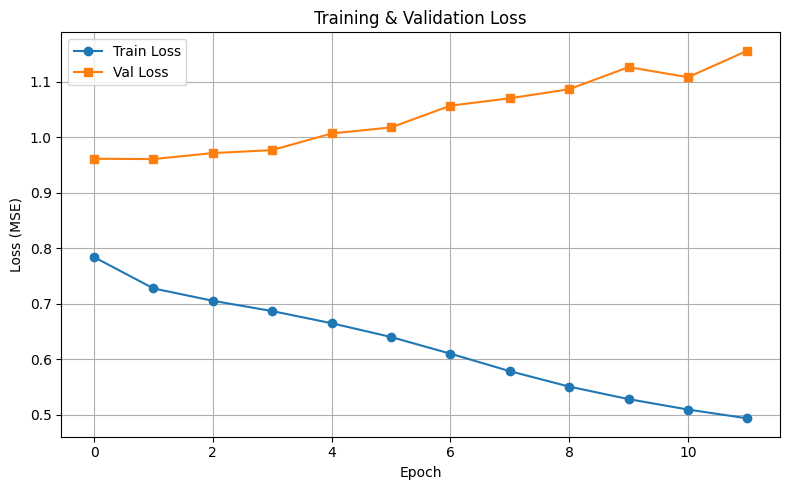

In [26]:
train_history = {"train_loss": [], "val_loss": []}
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for X_num, X_cat, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(X_num, X_cat).squeeze()  # (batch,)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_num, X_cat, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
            preds = model(X_num, X_cat).squeeze()
            loss = criterion(preds, y)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)

    train_history["train_loss"].append(avg_train_loss)
    train_history["val_loss"].append(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print(f"✅ Saved new best model (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print(" Early stopping triggered")
            break

plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train Loss", marker="o")
plt.plot(train_history["val_loss"], label="Val Loss", marker="s")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()